In [1]:
import os

os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [2]:
!curl ipinfo.io/json

{
  "ip": "206.190.237.59",
  "hostname": "206.190.237.59.16clouds.com",
  "city": "Osaka",
  "region": "Ōsaka",
  "country": "JP",
  "loc": "34.6938,135.5011",
  "org": "AS25820 IT7 Networks Inc",
  "postal": "543-0062",
  "timezone": "Asia/Tokyo",
  "readme": "https://ipinfo.io/missingauth"
}

Training set shape: (200000, 2)
Test set shape: (50000, 1)


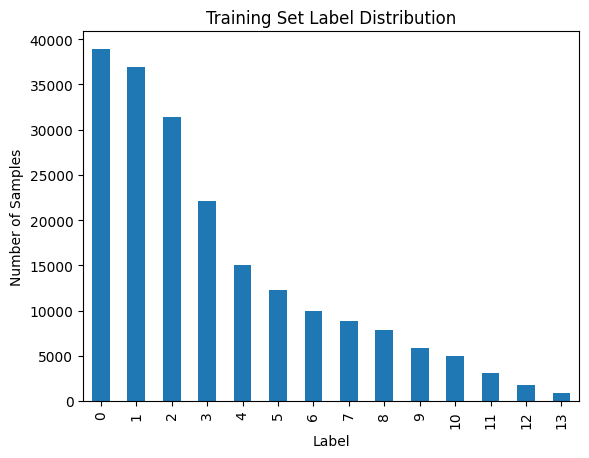

count    200000.000000
mean        907.207110
std         996.029036
min           2.000000
25%         374.000000
50%         676.000000
75%        1131.000000
max       57921.000000
Name: text_len, dtype: float64


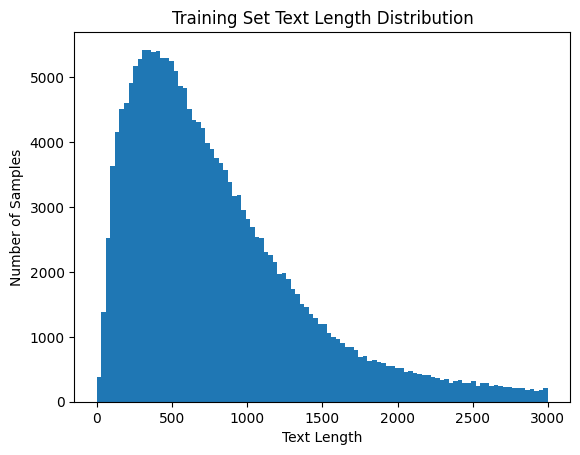

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取训练集和测试集数据
train_df = pd.read_csv('/root/autodl-tmp/train_set.csv', sep='\t')
test_df = pd.read_csv('/root/autodl-tmp/test_a.csv', sep='\t')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# 查看训练集标签分布
train_df['label'].value_counts().plot(kind='bar')
plt.title("Training Set Label Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.show()

# 统计训练集文本长度
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
print(train_df['text_len'].describe())

# 可视化文本长度分布
plt.hist(train_df['text_len'], bins=100, range=(0, 3000))
plt.title("Training Set Text Length Distribution")
plt.xlabel('Text Length')
plt.ylabel('Number of Samples')
plt.show()

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# 定义数据集类
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        if self.is_test:
            return {
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()
            }
        else:
            return {
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(self.data.iloc[index]['label'], dtype=torch.long)
            }

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 设置超参数
MAX_LEN = 512
BATCH_SIZE = 32

# 创建数据集和数据加载器
train_df_sample = train_df.sample(n=20000)  # 取 20000 条样本
train_dataset = NewsDataset(train_df_sample, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataset = NewsDataset(test_df, tokenizer, MAX_LEN, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

/root/anaconda3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

# 定义模型
class BertLSTMForNewsCls(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers):
        super(BertLSTMForNewsCls, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output[0]
        lstm_output, _ = self.lstm(sequence_output)

        attention_weights = torch.tanh(self.attention(lstm_output)).squeeze(-1)
        attention_weights = torch.softmax(attention_weights, dim=-1).unsqueeze(-1)
        weighted_output = lstm_output * attention_weights
        pooled_output = torch.sum(weighted_output, dim=1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# 设置超参数
NUM_CLASSES = 14
HIDDEN_DIM = 256
NUM_LAYERS = 2
EPOCHS = 30
LEARNING_RATE = 2e-5

In [6]:
# 创建模型并设置优化器和学习率调度器
model = BertLSTMForNewsCls(NUM_CLASSES, HIDDEN_DIM, NUM_LAYERS)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertLSTMForNewsCls(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
# 初始训练2万条数据
for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = model(input_ids, attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), "/root/newstextclassification/results/bert_news_cls_initial.pth")

Epoch [1/30], Loss: 1.9362
Epoch [2/30], Loss: 1.7026
Epoch [3/30], Loss: 1.5157
Epoch [4/30], Loss: 1.5563
Epoch [5/30], Loss: 0.7434
Epoch [6/30], Loss: 0.9243
Epoch [7/30], Loss: 0.4664
Epoch [8/30], Loss: 0.6260
Epoch [9/30], Loss: 0.7684
Epoch [10/30], Loss: 0.5566
Epoch [11/30], Loss: 0.7528
Epoch [12/30], Loss: 0.6032
Epoch [13/30], Loss: 0.6702
Epoch [14/30], Loss: 0.3923
Epoch [15/30], Loss: 0.4061
Epoch [16/30], Loss: 0.3631
Epoch [17/30], Loss: 0.6758
Epoch [18/30], Loss: 0.5236
Epoch [19/30], Loss: 0.3015
Epoch [20/30], Loss: 0.3923
Epoch [21/30], Loss: 0.2328
Epoch [22/30], Loss: 0.2965
Epoch [23/30], Loss: 0.4327
Epoch [24/30], Loss: 0.2435
Epoch [25/30], Loss: 0.1369
Epoch [26/30], Loss: 0.1255
Epoch [27/30], Loss: 0.1440
Epoch [28/30], Loss: 0.1283
Epoch [29/30], Loss: 0.0420
Epoch [30/30], Loss: 0.1011


In [9]:
# 分批微调前4个部分
for i in range(1, 5):  # 修改为4次微调
    # 选择未使用的2万条数据进行微调
    start_idx = 20000 + (i - 1) * 20000
    end_idx = 20000 + i * 20000
    train_df_part = train_df.iloc[start_idx:end_idx]

    train_dataset_part = NewsDataset(train_df_part, tokenizer, MAX_LEN)
    train_loader_part = DataLoader(train_dataset_part, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    # 加载上一个保存的模型权重
    if i == 1:
        model.load_state_dict(torch.load("/root/newstextclassification/results/bert_news_cls_initial.pth"))
    else:
        model.load_state_dict(torch.load(f"/root/newstextclassification/results/bert_news_cls_finetuned_part_{i-1}.pth"))
    model.to(device)

    total_steps_part = len(train_loader_part) * EPOCHS
    scheduler_part = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps_part)

    for epoch in range(EPOCHS):
        model.train()
        for batch in train_loader_part:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler_part.step()

        print(f'Batch {i}, Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

    # 保存模型
    torch.save(model.state_dict(), f"/root/newstextclassification/results/bert_news_cls_finetuned_part_{i}.pth")

Batch 1, Epoch [1/30], Loss: 0.6005
Batch 1, Epoch [2/30], Loss: 0.6865
Batch 1, Epoch [3/30], Loss: 0.3183
Batch 1, Epoch [4/30], Loss: 0.0580
Batch 1, Epoch [5/30], Loss: 0.1647
Batch 1, Epoch [6/30], Loss: 0.1125
Batch 1, Epoch [7/30], Loss: 0.5367
Batch 1, Epoch [8/30], Loss: 0.0384
Batch 1, Epoch [9/30], Loss: 0.1480
Batch 1, Epoch [10/30], Loss: 0.0205
Batch 1, Epoch [11/30], Loss: 0.1976
Batch 1, Epoch [12/30], Loss: 0.0010
Batch 1, Epoch [13/30], Loss: 0.0312
Batch 1, Epoch [14/30], Loss: 0.0028
Batch 1, Epoch [15/30], Loss: 0.0001
Batch 1, Epoch [16/30], Loss: 0.3617
Batch 1, Epoch [17/30], Loss: 0.0000
Batch 1, Epoch [18/30], Loss: 0.0000
Batch 1, Epoch [19/30], Loss: 0.3943
Batch 1, Epoch [20/30], Loss: 0.0000
Batch 1, Epoch [21/30], Loss: 0.0000
Batch 1, Epoch [22/30], Loss: 0.4036
Batch 1, Epoch [23/30], Loss: 0.0000
Batch 1, Epoch [24/30], Loss: 0.1921
Batch 1, Epoch [25/30], Loss: 0.0000
Batch 1, Epoch [26/30], Loss: 0.3020
Batch 1, Epoch [27/30], Loss: 0.0000
Batch 1, E

In [ ]:
# 从part5开始继续微调
for i in range(5, 10):
    # 选择未使用的2万条数据进行微调
    start_idx = 20000 + (i - 1) * 20000
    end_idx = 20000 + i * 20000
    train_df_part = train_df.iloc[start_idx:end_idx]

    train_dataset_part = NewsDataset(train_df_part, tokenizer, MAX_LEN)
    train_loader_part = DataLoader(train_dataset_part, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    # 加载上一个保存的模型权重
    model.load_state_dict(torch.load(f"/root/newstextclassification/results/bert_news_cls_finetuned_part_{i-1}.pth"))
    model.to(device)

    total_steps_part = len(train_loader_part) * EPOCHS
    scheduler_part = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps_part)

    for epoch in range(EPOCHS):
        model.train()
        for batch in train_loader_part:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler_part.step()

        print(f'Batch {i}, Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

    # 保存模型
    torch.save(model.state_dict(), f"/root/newstextclassification/results/bert_news_cls_finetuned_part_{i}.pth")

Batch 5, Epoch [1/30], Loss: 0.4461
Batch 5, Epoch [2/30], Loss: 0.3668
Batch 5, Epoch [3/30], Loss: 0.2849
Batch 5, Epoch [4/30], Loss: 0.3242
Batch 5, Epoch [5/30], Loss: 0.0000
Batch 5, Epoch [6/30], Loss: 0.2323
Batch 5, Epoch [7/30], Loss: 0.0005
Batch 5, Epoch [8/30], Loss: 0.0061
Batch 5, Epoch [9/30], Loss: 0.1240
Batch 5, Epoch [10/30], Loss: 0.3927
Batch 5, Epoch [11/30], Loss: 0.0001
Batch 5, Epoch [12/30], Loss: 0.0000
Batch 5, Epoch [13/30], Loss: 0.0000
Batch 5, Epoch [14/30], Loss: 0.0000
Batch 5, Epoch [15/30], Loss: 0.0000
Batch 5, Epoch [16/30], Loss: 0.0000
Batch 5, Epoch [17/30], Loss: 0.0000
Batch 5, Epoch [18/30], Loss: 0.0000
Batch 5, Epoch [19/30], Loss: 0.0000
Batch 5, Epoch [20/30], Loss: 0.0011
Batch 5, Epoch [21/30], Loss: 0.0000
Batch 5, Epoch [22/30], Loss: 0.0000
Batch 5, Epoch [23/30], Loss: 0.0000
Batch 5, Epoch [24/30], Loss: 0.0000
Batch 5, Epoch [25/30], Loss: 0.0000
Batch 5, Epoch [26/30], Loss: 0.0000
Batch 5, Epoch [27/30], Loss: 0.0000
Batch 5, E

In [7]:
# 从part5开始继续微调
for i in range(7, 10):
    # 选择未使用的2万条数据进行微调
    start_idx = 20000 + (i - 1) * 20000
    end_idx = 20000 + i * 20000
    train_df_part = train_df.iloc[start_idx:end_idx]

    train_dataset_part = NewsDataset(train_df_part, tokenizer, MAX_LEN)
    train_loader_part = DataLoader(train_dataset_part, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    # 加载上一个保存的模型权重
    model.load_state_dict(torch.load(f"/root/newstextclassification/results/bert_news_cls_finetuned_part_{i-1}.pth"))
    model.to(device)

    total_steps_part = len(train_loader_part) * EPOCHS
    scheduler_part = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps_part)

    for epoch in range(EPOCHS):
        model.train()
        for batch in train_loader_part:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler_part.step()

        print(f'Batch {i}, Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

    # 保存模型
    torch.save(model.state_dict(), f"/root/newstextclassification/results/bert_news_cls_finetuned_part_{i}.pth")

Batch 7, Epoch [1/30], Loss: 0.2327
Batch 7, Epoch [2/30], Loss: 0.0248
Batch 7, Epoch [3/30], Loss: 0.3002
Batch 7, Epoch [4/30], Loss: 0.2124
Batch 7, Epoch [5/30], Loss: 0.1366
Batch 7, Epoch [6/30], Loss: 1.1970
Batch 7, Epoch [7/30], Loss: 0.0294
Batch 7, Epoch [8/30], Loss: 0.0001
Batch 7, Epoch [9/30], Loss: 0.2043
Batch 7, Epoch [10/30], Loss: 0.6569
Batch 7, Epoch [11/30], Loss: 0.0000
Batch 7, Epoch [12/30], Loss: 0.4875
Batch 7, Epoch [13/30], Loss: 0.0000
Batch 7, Epoch [14/30], Loss: 0.0000
Batch 7, Epoch [15/30], Loss: 0.0000
Batch 7, Epoch [16/30], Loss: 0.0000
Batch 7, Epoch [17/30], Loss: 0.0000
Batch 7, Epoch [18/30], Loss: 0.0000
Batch 7, Epoch [19/30], Loss: 0.0000
Batch 7, Epoch [20/30], Loss: 0.0000
Batch 7, Epoch [21/30], Loss: 0.0000
Batch 7, Epoch [22/30], Loss: 0.0000
Batch 7, Epoch [23/30], Loss: 0.0000
Batch 7, Epoch [24/30], Loss: 0.0000
Batch 7, Epoch [25/30], Loss: 0.0606
Batch 7, Epoch [26/30], Loss: 0.0000
Batch 7, Epoch [27/30], Loss: 0.0000
Batch 7, E

In [9]:
import torch
from transformers import BertTokenizer
import pandas as pd

# 加载训练好的模型
model = BertLSTMForNewsCls(NUM_CLASSES, HIDDEN_DIM, NUM_LAYERS)
model.load_state_dict(torch.load("/root/newstextclassification/results/bert_news_cls_finetuned_part_9.pth"))
model.to(device)
model.eval()

# 读取待预测的数据
test_df = pd.read_csv('/root/autodl-tmp/test_a.csv', sep='\t')
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
test_dataset = NewsDataset(test_df, tokenizer, MAX_LEN, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 对新数据进行预测
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

# 生成提交文件
submission = pd.DataFrame({'label': predictions})
submission.to_csv('/root/newstextclassification/results/news_submission_2.csv', index=False)

print("Prediction finished. Submission file generated.")

Prediction finished. Submission file generated.
